# Capstone Project. New place of residence

## Table Of Contents
- Introduction
- Description of data sources
- Methodology
- Result
- Discussion
- Conclusion

## 1. Introduction: Business Problem

In this project, we will try to find the best place to live for a young person who has decided to change jobs and move to Moscow from St. Petersburg. This report will be of interest to anyone who wants to change their place of residence to Moscow.

We will assume that the current place of residence suits the person in the part of the various venues around it and he wants the new place of residence to be as similar as possible to the current one. He also wants the new location will be within 500m of any metro station. Venues that are important to him and that he takes into account when evaluating a new place of residence:
- Restaurants
- Bars
- Сafes
- Fitness centers
- Clubs
- Pharmacies
- Movie theaters
- Pools
- Shopping Malls
- Supermarkets
- Various stores

Using data science, we will determine the most suitable place of residence for a young person, taking into account the above criteria.

## 2. Description of data sources

The introductory information for our project will be the address of a young person in St. Petersburg, as well as the address of his new place of work in Moscow. We will use the Google Maps API to get the coordinates of these addresses. And using the Foursquare API, we will get a list of the necessary venues around the current place of residence.

To solve this problem, we will need a list of metro stations with their coordinates. We will take it here [list of metro stations](https://ru.wikipedia.org/wiki/Список_станций_Московского_метрополитена). Using the Foursquare API, we will get a list of the necessary venues within a radius of 500m around each metro station.

We will search for the area most similar to the current place of residence. All other things being equal, the area closest to the address of the place of work will be finally recommended.

## 3. Methodology

In [461]:
# Import requied libraries
import requests
import pandas as pd
import numpy as np
import json
import geopy
import folium
import shapely.geometry
import pyproj
import math
import re
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from shapely.geometry import shape, Point
from functools import partial
from pyproj import Proj, transform
from pyproj import Transformer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from sklearn.preprocessing import StandardScaler
from urllib.parse import quote, urlsplit, urlunsplit

### 3.1 Data Collection, Understanding, Preparation

The input data for the project are:
- the address of a young person in St. Petersburg
- the address of his new place of work in Moscow

If the project will be embedded somewhere, you can get this data using the input () function. But here we'll just set them as string variables.
1. The address in St. Petersburg

In [462]:
SP_addr = "проспект Стачек, 92к2, Санкт-Петербург, Россия"

2. The address in Moscow

In [463]:
Mos_addr = "Ленинский проспект, 69, Москва, Россия"

For the project, we need a list of metro stations. In Moscow, in addition to the metro, there is the Moscow Central Circle (MCC). It is equivalent to the metro, because trains run at the same frequency as the metro. In addition, there are pedestrian crossings between the stations, and one ticket is valid. We will take the data from Wikipedia [List of Moscow Metro stations](https://ru.wikipedia.org/wiki/Список_станций_Московского_метрополитена). There are several tables there. We will need: 
- the Stations of the Moscow Metro 
- the Platforms of the Moscow Central Ring

Load the data into two dataframes. Since the address bar contains Russian characters, we need to pre-process the URL using the function.

In [464]:
# If the address bar contains Russian characters, use the function:
def iri_to_uri(iri):
    parts = urlsplit(iri)
    uri = urlunsplit((
        parts.scheme, 
        parts.netloc.encode('idna').decode('ascii'), 
        quote(parts.path),
        quote(parts.query, '='),
        quote(parts.fragment),
    ))
    return uri

url = "https://ru.wikipedia.org/wiki/Список_станций_Московского_метрополитена"

# the Stations of the Moscow Metro
df1 = pd.read_html(iri_to_uri(url))[3]
# the Platforms of the Moscow Central Ring
df2 = pd.read_html(iri_to_uri(url))[5]

In [465]:
df1.head()

,Unnamed: 0,Название станцииПрежние названия,Датаоткрытия,Пере-садки,"Глубина,м[2]",Тип конструкции,Координаты,Вид станции
0,NaN,Бульвар РокоссовскогоУлица Подбельского (до 2014),1 августа 1990,NaN,−8,колоннаямелкого заложениятрёхпролётная,55°48′53″ с. ш. 37°44′03″ в. д.HЯ,NaN
1,NaN,Черкизовская,1 августа 1990,NaN,−9,односводчатаямелкого заложения,55°48′14″ с. ш. 37°44′41″ в. д.HЯ,NaN
2,NaN,Преображенская площадь,31 декабря 1965,NaN,−8,колоннаямелкого заложениятрёхпролётная,55°47′47″ с. ш. 37°42′54″ в. д.HЯ,NaN
3,NaN,Сокольники,15 мая 1935,NaN,−9,колоннаямелкого заложениятрёхпролётная,55°47′20″ с. ш. 37°40′49″ в. д.HЯ,NaN
4,NaN,Красносельская,15 мая 1935,NaN,−8,колоннаямелкого заложениядвухпролётная,55°46′48″ с. ш. 37°40′02″ в. д.HЯ,NaN


Some metro stations are now closed. We need to delete these records.

In [466]:
# delete the closed stations
df1 = df1[~df1["Название станцииПрежние названия"].str.contains("закрыта")]

In the uploaded data, the coordinates of the stations are represented as degrees, hours, and minutes. We need to convert them to decimal coordinates. To do this, we will use the function, write the results to the new columns of the dataframe, and convert the data to the type "float".

In [467]:
# A function that converts degrees, hours, and seconds to decimal latitude and longitude
def calc_lat(coords):
    m = re.search(r"(\d\d)°(\d\d)′(\d\d)″\xa0с.\xa0ш. (\d\d)°(\d\d)′(\d\d)″\xa0в.\xa0д.HЯ",coords)
    lat = float(int(m.group(1)) + int(m.group(2)) / 60.0 + int(m.group(3)) / 3600.0)
    lon = float(int(m.group(4)) + int(m.group(5)) / 60.0 + int(m.group(6)) / 3600.0)
    loc = [lat, lon]
    return loc

# Сonverting degrees, hours, and seconds to decimal latitude and longitude
df1["Location"] = df1['Координаты'].apply(lambda x: calc_lat(x))
df1["Latitude"] = df1['Location'].apply(lambda x: x[0]).astype('float')
df1["Longitude"] = df1['Location'].apply(lambda x: x[1]).astype('float')
df2["Location"] = df2["Московское центральное кольцо","Координаты"].apply(lambda x: calc_lat(x))
df2["Latitude"] = df2['Location'].apply(lambda x: x[0]).astype('float')
df2["Longitude"] = df2['Location'].apply(lambda x: x[1]).astype('float')

If a metro station has changed its name, its name is loaded in the "New nameOld name" format. So we have to cut off the old name. Let's do this using the function:

In [468]:
# A function that leaves a new name of the station
def new_name(name):
    m = re.search(r"(^.*[а-я])[А-Я,0-9]", name)
    if m is not None:
        return m.group(1)
    else:
        return name
    
# Leave only the new station names
df1["Metro_name"] = df1['Название станцииПрежние названия'].apply(lambda x: new_name(x))

Next, we need to collect the necessary attributes in a single dataframe and delete the missing data.

In [469]:
# Collect the necessary attributes in one dataframe

metro_df = pd.DataFrame({"Type" : pd.Series(["Metro"]*df1.shape[0]),
                         "Metro_name" : df1["Metro_name"],
                         "Location" : df1["Location"],
                         "Latitude" : df1["Latitude"],
                         "Longitude" : df1["Longitude"]
                        })

# adding stations of the Moscow central circle
metro_df = metro_df.append(pd.DataFrame({"Type" : pd.Series(["MCC"]*df2.shape[0]),
                         "Metro_name" : df2["Московское центральное кольцо","Название станции"],
                         "Location" : df2["Location"],
                         "Latitude" : df2["Latitude"],
                         "Longitude" : df2["Longitude"]
                        })
)

metro_df = metro_df.dropna()

To solve our problem, we will use clustering. Therefore, we will also add a location in St. Petersburg to the dataframe. But at first We need use the Google Maps API to get the coordinates of the address.

In [470]:
# create class instance of Nominatim
geolocator = Nominatim(user_agent="foursquare_agent", timeout=2)

location = geolocator.geocode(SP_addr)
SP_latitude = location.latitude
SP_longitude = location.longitude
SP_location = [SP_latitude, SP_longitude]
print('Coordinate of "{}": {}, {}'.format(SP_addr, SP_latitude, SP_longitude))

Coordinate of "проспект Стачек, 92к2, Санкт-Петербург, Россия": 59.862909, 30.2602144


Add a location in St. Petersburg to the dataframe

In [471]:
metro_df = metro_df.append(pd.DataFrame({"Type" : "S-Pt",
                         "Metro_name" : "St. Petersburg",
                         "Location" : [SP_location],
                         "Latitude" : SP_latitude,
                         "Longitude" : SP_longitude
                        })
)

Building a new index

In [472]:
metro_df = metro_df.reset_index()
del metro_df["index"]
metro_df.tail()

,Type,Metro_name,Location,Latitude,Longitude
256,MCC,Стрешнево,"[55.81361111111111, 37.48694444444445]",55.813611,37.486944
257,MCC,Балтийская,"[55.825833333333335, 37.49611111111111]",55.825833,37.496111
258,MCC,Коптево,"[55.83972222222222, 37.519999999999996]",55.839722,37.520000
259,MCC,Лихоборы,"[55.84722222222222, 37.55138888888889]",55.847222,37.551389
260,S-Pt,St. Petersburg,"[59.862909, 30.2602144]",59.862909,30.260214


Since the names of the stations can be duplicated, we will assign each station its own ID.

In [473]:
# Assign each station its own ID
metro_df.insert(0, 'ID_Station', metro_df.index)
metro_df.head()

,ID_Station,Type,Metro_name,Location,Latitude,Longitude
0,0,Metro,Бульвар Рокоссовского,"[55.81472222222222, 37.73416666666667]",55.814722,37.734167
1,1,Metro,Черкизовская,"[55.803888888888885, 37.74472222222222]",55.803889,37.744722
2,2,Metro,Преображенская площадь,"[55.796388888888885, 37.715]",55.796389,37.715000
3,3,Metro,Сокольники,"[55.788888888888884, 37.680277777777775]",55.788889,37.680278
4,4,Metro,Красносельская,"[55.78, 37.66722222222222]",55.780000,37.667222


Now we can display the Moscow metro and MCC stations on the map. We will display metro stations in blue, and MCC stations in red. We will not display the location in St. Petersburg. The center of the map will be the center of Moscow. We need to find the coordinates of this place.

In [474]:
addr = 'Moscow, Red Square'

# create class instance of Nominatim
geolocator = Nominatim(user_agent="foursquare_agent", timeout=2)

location = geolocator.geocode(addr)
latitude = location.latitude
longitude = location.longitude
Moscow_center = [latitude, longitude]
print('Coordinate of {}: {}'.format(addr, Moscow_center))

Coordinate of Moscow, Red Square: [55.7536283, 37.62137960067377]


Now we can display the map

In [475]:
# Visualizing metro stations on the map
map_moscow = folium.Map(location=Moscow_center, zoom_start=11)

for t, name, lat, lon in zip(metro_df["Type"], metro_df["Metro_name"],metro_df['Latitude'], metro_df['Longitude']):
    
    if t == 'S-Pt': continue
    folium.features.CircleMarker(
        [lat, lon],
        radius=2, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=folium.Popup('{}'.format(name), parse_html=True),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_moscow)
    
    if t == "Metro":
        color = 'blue'
    else:
        color = 'red'
    folium.Circle([lat, lon], radius=200, color=color, fill=False).add_to(map_moscow)

map_moscow

Now that we have our location candidates, let's use the Foursquare API to get information about venues within a 500m radius of metro stations.

In [476]:
# Define Foursquare Credentials and Version

To extract the category name, we will use the function

In [477]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We will collect preliminary data in one dataframe

In [481]:
columns = ['ID_Station', 'categories', 'lat', 'lng']
metro_venues_prev = pd.DataFrame(columns = columns)
metro_venues_prev

,ID_Station,categories,lat,lng


In [482]:
LIMIT = 100
radius = 500

for num, ser in metro_df.iterrows():

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        ser.Latitude, 
        ser.Longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()
    try:
        venues = results['response']['groups'][0]['items']
        nearby_venues = pd.json_normalize(venues) # flatten JSON
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues = nearby_venues.loc[:, filtered_columns]

        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        nearby_venues["ID_Station"] = ser.ID_Station

        metro_venues_prev = metro_venues_prev.append(nearby_venues)
        
    except Exception as err:
        print(err)
        print(results)
        pass

We are interested in the following categories of venues:
- Restaurants
- Bars
- Сafes
- Fitness centers
- Clubs
- Pharmacies
- Movie theaters
- Pools
- Shopping Malls
- Supermarkets
- Various stores

We will collect the necessary venues in the dataframe metro_venues. 

In [483]:
columns = ['ID_Station', 'categories', 'shortName', 'lat', 'lng']
metro_venues = pd.DataFrame(columns = columns)
metro_venues

,ID_Station,categories,shortName,lat,lng


We will add entries for each condition.<p>
1. To get restaurants, we will filter the categories that contain "restaurant" and "Restaurant"

In [484]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("restaurant")]
df.insert(2, 'shortName', 'Restaurant')
metro_venues = metro_venues.append(df)
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Restaurant")]
df.insert(2, 'shortName', 'Restaurant')
metro_venues = metro_venues.append(df)

2. To get bars, we will filter the categories that contain whole word "Bar"

In [485]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains(r'.*\bBar\b.*')]
df.insert(2, 'shortName', 'Bar')
metro_venues = metro_venues.append(df)

3. To get Сafes, we will filter the categories that contain "Cafe", "Bakery" or "Coffee"

In [486]:
df = metro_venues_prev[(metro_venues_prev["categories"].str.contains("Cafe")) |
                       (metro_venues_prev["categories"].str.contains("Bakery")) |
                       (metro_venues_prev["categories"].str.contains("Coffee"))
                      ]
df.insert(2, 'shortName', 'Cafe')
metro_venues = metro_venues.append(df)

4. To get Fitness centers, we will filter the categories that contain "Gym"

In [487]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Gym")]
df.insert(2, 'shortName', 'Fitness center')
metro_venues = metro_venues.append(df)

5. To get Clubs, we will filter the categories that contain "Club"

In [488]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Club")]
df.insert(2, 'shortName', 'Club')
metro_venues = metro_venues.append(df)

6. To get Pharmacies, we will filter the categories that contain "Drugstore" or "Pharmacy"

In [489]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Drugstore") | 
                       metro_venues_prev["categories"].str.contains("Pharmacy")]
df.insert(2, 'shortName', 'Pharmacy')
metro_venues = metro_venues.append(df)

7. To get Movie theaters, we will filter the categories that contain "Movie"

In [490]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Movie")]
df.insert(2, 'shortName', 'Movie')
metro_venues = metro_venues.append(df)

8. To get pools, it is necessary that the category is equal "Pool"

In [491]:
df = metro_venues_prev[metro_venues_prev.categories == 'Pool']
df.insert(2, 'shortName', 'Pool')
metro_venues = metro_venues.append(df)

9. To get Shopping Malls, we will filter the categories that contain "Mall"

In [492]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Mall")]
df.insert(2, 'shortName', 'Mall')
metro_venues = metro_venues.append(df)

10. To get Supermarkets, we will filter the categories that contain "Supermarket"

In [493]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("Supermarket")]
df.insert(2, 'shortName', 'Supermarket')
metro_venues = metro_venues.append(df)

11. To get Various stores, we will filter the categories that contain "store" or "Store"

In [494]:
df = metro_venues_prev[metro_venues_prev["categories"].str.contains("store") | 
                       metro_venues_prev["categories"].str.contains("Store")]
df.insert(2, 'shortName', 'Store')
metro_venues = metro_venues.append(df)

Now we have collected the final information for our analysis

In [495]:
metro_venues.head()

,ID_Station,categories,shortName,lat,lng,name
3,5,Varenyky restaurant,Restaurant,55.774982,37.656780,Вареничная №1
2,90,Varenyky restaurant,Restaurant,55.774982,37.656780,Вареничная №1
3,0,American Restaurant,Restaurant,55.814026,37.733659,Бургер кинг
4,0,Vietnamese Restaurant,Restaurant,55.815955,37.736421,Фо & Ролл
6,0,Tex-Mex Restaurant,Restaurant,55.815503,37.737244,El Taco


The size of the resulting dataframe

In [496]:
metro_venues.shape

(4578, 6)

### 3.2 Modeling and Deployment: Analyze Each Metro Station

Let's check how many venues were returned for each metro station

In [497]:
metro_venues.groupby('ID_Station').count()

,categories,shortName,lat,lng,name
ID_Station,,,,,
0,14,14,14,14,14
1,11,11,11,11,11
2,23,23,23,23,23
3,8,8,8,8,8
4,8,8,8,8,8
...,...,...,...,...,...
256,5,5,5,5,5
257,51,51,51,51,51
258,5,5,5,5,5


In [498]:
# one hot encoding
metro_onehot = pd.get_dummies(metro_venues[['shortName']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
metro_onehot['ID_Station'] = metro_venues['ID_Station'] 

# move neighborhood column to the first column
fixed_columns = [metro_onehot.columns[-1]] + list(metro_onehot.columns[:-1])
metro_onehot = metro_onehot[fixed_columns]

metro_onehot.head()

,ID_Station,Bar,Cafe,Club,Fitness center,Mall,Movie,Pharmacy,Pool,Restaurant,Store,Supermarket
3,5,0,0,0,0,0,0,0,0,1,0,0
2,90,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0


Next, group rows by ID Metro Station and by taking the mean of the frequency of occurrence of each category

In [499]:
metro_grouped = metro_onehot.groupby('ID_Station').mean().reset_index()
metro_grouped

,ID_Station,Bar,Cafe,Club,Fitness center,Mall,Movie,Pharmacy,Pool,Restaurant,Store,Supermarket
0,0,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.428571,0.357143,0.000000
1,1,0.272727,0.090909,0.090909,0.181818,0.000000,0.0,0.000000,0.000000,0.090909,0.181818,0.090909
2,2,0.000000,0.217391,0.000000,0.130435,0.000000,0.0,0.173913,0.000000,0.130435,0.304348,0.043478
3,3,0.125000,0.000000,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.250000,0.500000,0.000000
4,4,0.125000,0.250000,0.000000,0.125000,0.000000,0.0,0.125000,0.000000,0.125000,0.125000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...
247,256,0.000000,0.200000,0.000000,0.400000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000
248,257,0.000000,0.156863,0.000000,0.019608,0.039216,0.0,0.019608,0.000000,0.137255,0.607843,0.019608
249,258,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.200000,0.000000,0.200000,0.200000,0.400000
250,259,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.333333,0.000000,0.333333,0.000000


In [500]:
metro_grouped.shape

(252, 12)

<h3> Cluster Metro Stations </h3>

We will try to find the most similar place to stay when moving from St. Petersburg.

So try segmenting the areas around metro stations using K-Means, using the elbow method, to find the Areas most similar to the area in St. Petersburg.

To determine the optimal number of clusters, we will use the elbow visualization. To do this, we define the function _KMeans_elbow_.

In [501]:
def KMeans_elbow(X, max_clusters=10):
   
    inertias = [] 
    K = range(1,max_clusters) 
     
    for k in K: 
        #Building and fitting the model 
        kmeans = KMeans(init = "k-means++", n_clusters=k, random_state=0, n_init = 12)
        kmeans.fit(X) 
        inertias.append(kmeans.inertia_) 
       
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.show()

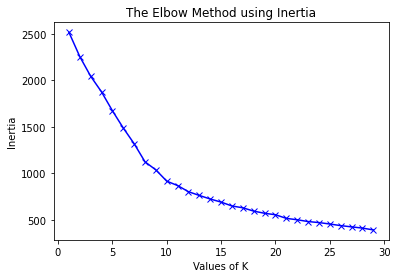

In [502]:
# prepare dataset for K-means clustering
X2 = metro_grouped_clustering 

# Normalizing over the standard deviation
X2 = StandardScaler().fit_transform(X2)

# itterate from 1 to 30 n_clusters, calculate inertia and` visualize it
KMeans_elbow1(X2, 30)

The graph shows that the optimal number of clusters is 13. Since a further increase in the number of clusters does not lead to a significant improvement in the accuracy of the model.

In [503]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 13

metro_grouped_clustering = metro_grouped.drop('ID_Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(metro_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 0,  2,  1, 10,  3,  3,  3,  8,  8,  0])

Let's add the cluster to the data frame with the average frequency of occurrence of each category.

In [504]:
metro_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
metro_grouped

,Cluster Labels,ID_Station,Bar,Cafe,Club,Fitness center,Mall,Movie,Pharmacy,Pool,Restaurant,Store,Supermarket
0,0,0,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.428571,0.357143,0.000000
1,2,1,0.272727,0.090909,0.090909,0.181818,0.000000,0.0,0.000000,0.000000,0.090909,0.181818,0.090909
2,1,2,0.000000,0.217391,0.000000,0.130435,0.000000,0.0,0.173913,0.000000,0.130435,0.304348,0.043478
3,10,3,0.125000,0.000000,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.250000,0.500000,0.000000
4,3,4,0.125000,0.250000,0.000000,0.125000,0.000000,0.0,0.125000,0.000000,0.125000,0.125000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2,256,0.000000,0.200000,0.000000,0.400000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000
248,10,257,0.000000,0.156863,0.000000,0.019608,0.039216,0.0,0.019608,0.000000,0.137255,0.607843,0.019608
249,9,258,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.200000,0.000000,0.200000,0.200000,0.400000
250,1,259,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.333333,0.000000,0.333333,0.000000


Then we will add the cluster to a copy of the data frame with the coordinates of the metro stations to be able to experiment with the number of clusters.

In [505]:
metro_station = metro_df.copy()
metro_station = metro_station.merge(metro_grouped[['Cluster Labels','ID_Station']])
metro_station

,ID_Station,Type,Metro_name,Location,Latitude,Longitude,Cluster Labels
0,0,Metro,Бульвар Рокоссовского,"[55.81472222222222, 37.73416666666667]",55.814722,37.734167,0
1,1,Metro,Черкизовская,"[55.803888888888885, 37.74472222222222]",55.803889,37.744722,2
2,2,Metro,Преображенская площадь,"[55.796388888888885, 37.715]",55.796389,37.715000,1
3,3,Metro,Сокольники,"[55.788888888888884, 37.680277777777775]",55.788889,37.680278,10
4,4,Metro,Красносельская,"[55.78, 37.66722222222222]",55.780000,37.667222,3
...,...,...,...,...,...,...,...
247,256,MCC,Стрешнево,"[55.81361111111111, 37.48694444444445]",55.813611,37.486944,2
248,257,MCC,Балтийская,"[55.825833333333335, 37.49611111111111]",55.825833,37.496111,10
249,258,MCC,Коптево,"[55.83972222222222, 37.519999999999996]",55.839722,37.520000,9
250,259,MCC,Лихоборы,"[55.84722222222222, 37.55138888888889]",55.847222,37.551389,1


### Visualize the resulting clusters

Let's display the distribution of metro stations by cluster on the histogram.

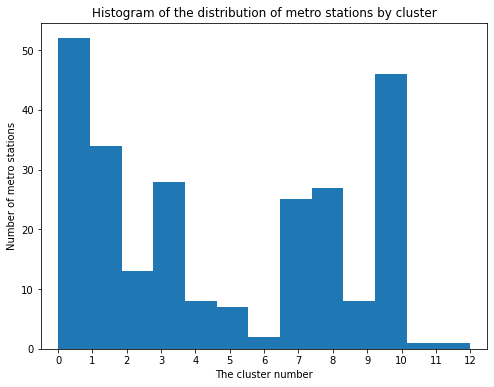

In [506]:
metro_station['Cluster Labels'].plot(kind='hist', 
                                     bins=kclusters, 
                                     figsize=(8, 6), 
                                     xticks = range(kclusters+1),
                                     xlim=(-0.5, kclusters-0.5)
                                    )

plt.title('Histogram of the distribution of metro stations by cluster') # add a title to the histogram
plt.ylabel('Number of metro stations') # add y-label
plt.xlabel('The cluster number') # add x-label

plt.show()

The histogram shows that the distribution of metro stations to clusters is uneven. Let's now look at this distribution on the map. Let's display which cluster the address in St. Petersburg is in.

#### Saint-Petersburg map

In [507]:
map_clusters = folium.Map(location=SP_location, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, t, cluster in zip(metro_station['Latitude'], metro_station['Longitude'], metro_station['Metro_name'], metro_station['Type'], metro_station['Cluster Labels']):
    if t == 'S-Pt':
        label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=15,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Moscow map

Let's display which clusters the Moscow metro stations are located in.

In [508]:
map_clusters = folium.Map(location=Moscow_center, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, t, cluster in zip(metro_station['Latitude'], metro_station['Longitude'], metro_station['Metro_name'], metro_station['Type'], metro_station['Cluster Labels']):
    if t == 'S-Pt': continue
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Results

Now we can find which locations are most similar to a person's current place of residence. The cluster that was defined for the address in St. Petersburg is:

In [509]:
SP_claster = metro_station[metro_station.Type == 'S-Pt']['Cluster Labels'].values[0]
print('The cluster that was defined for the address in St. Petersburg is {}'.format(SP_claster))

The cluster that was defined for the address in St. Petersburg is 10


Let's display on the map of Moscow the metro stations that have been identified in cluster 4. We will also display the new place of work of the young person on the map. To do this, first find the coordinates of the Moscow address.

In [510]:
# create class instance of Nominatim
geolocator = Nominatim(user_agent="foursquare_agent", timeout=2)

location = geolocator.geocode(Mos_addr)
Mos_latitude = location.latitude
Mos_longitude = location.longitude
Mos_location = [Mos_latitude, Mos_longitude]
print('Coordinate of "{}": {}, {}'.format(Mos_addr, Mos_latitude, Mos_longitude))

Coordinate of "Ленинский проспект, 69, Москва, Россия": 55.6898692, 37.5496764


In [511]:
map_clusters = folium.Map(location=Moscow_center, zoom_start=11)
folium.Marker(Mos_location, popup='New place of work').add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, t, cluster in zip(metro_station['Latitude'], metro_station['Longitude'], metro_station['Metro_name'], metro_station['Type'], metro_station['Cluster Labels']):
    if cluster != SP_claster: continue
    label = folium.Popup(str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, from the selected locations, we need to select the most suitable one. The criterion will be the proximity to the new place of work. To do this, we need to calculate the distance from each metro station the new place of work. Let's assemble the metro stations from cluster 4 into a separate dataframe.

In [512]:
final_stations = metro_station[(metro_station['Cluster Labels'] == SP_claster) &
                               (metro_station['Type'] != 'S-Pt')]
final_stations = final_stations.reset_index()
del final_stations['index']
final_stations

,ID_Station,Type,Metro_name,Location,Latitude,Longitude,Cluster Labels
0,3,Metro,Сокольники,"[55.788888888888884, 37.680277777777775]",55.788889,37.680278,10
1,16,Metro,Университет,"[55.692499999999995, 37.53333333333333]",55.692500,37.533333,10
2,43,Metro,Каширская,"[55.655, 37.64861111111111]",55.655000,37.648611,10
3,47,Metro,Домодедовская,"[55.61083333333333, 37.718611111111116]",55.610833,37.718611,10
4,52,Metro,Волоколамская,"[55.83527777777778, 37.382222222222225]",55.835278,37.382222,10
5,56,Metro,Молодёжная,"[55.740833333333335, 37.416666666666664]",55.740833,37.416667,10
6,58,Metro,Славянский бульвар,"[55.72972222222222, 37.470555555555556]",55.729722,37.470556,10
7,60,Metro,Киевская,"[55.74444444444445, 37.565555555555555]",55.744444,37.565556,10
8,66,Metro,Семёновская,"[55.78333333333333, 37.72083333333334]",55.783333,37.720833,10
9,69,Metro,Первомайская,"[55.79472222222222, 37.799166666666665]",55.794722,37.799167,10


In order to calculate the distance from the new place of work to the metro station, we first need to translate the longitude and latitude into XY-coordinates. To do this, use the functions.

In [513]:
def lonlat_to_xy(loc):
    lon = loc[1]
    lat = loc[0]
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    transformer = Transformer.from_crs( {"proj":'longlat', "datum":'WGS84'}, {"proj":'utm', "zone":33, "datum":'WGS84'} ) #"epsg:3857")
    # transformer = Transformer.from_crs(proj_latlon, proj_xy) # "epsg:3857")
    xy = transformer.transform(lon, lat)
    return [xy[0], xy[1]]   

Find the coordinates of a new place of work in Moscow

In [514]:
Mos_x, Mos_y = lonlat_to_xy(Mos_location)
print('Coordinates of a new place of work in Moscow are: x = {}, y = {}'.format(Mos_x, Mos_y))

Coordinates of a new place of work in Moscow are: x = 1903456.8958864515, y = 6404603.829328073


Let's define a function with which we will find the distance

In [515]:
def calc_xy_distance(coords):
    x1 = coords[0]
    y1 = coords[1]
    dx = Mos_x - x1
    dy = Mos_y - y1
    return math.sqrt(dx*dx + dy*dy)

And then calculate the distance. Adding XY-coordinates and the distance to a separate columns of the new dataframe.

In [516]:
final_stations['XY'] = final_stations['Location'].apply(lonlat_to_xy)
final_stations['dist'] = final_stations['XY'].apply(calc_xy_distance)
final_stations.head()

,ID_Station,Type,Metro_name,Location,Latitude,Longitude,Cluster Labels,XY,dist
0,3,Metro,Сокольники,"[55.788888888888884, 37.680277777777775]",55.788889,37.680278,10,"[1907723.7946554183, 6418011.713694123]",14070.457998
1,16,Metro,Университет,"[55.692499999999995, 37.53333333333333]",55.692500,37.533333,10,"[1902364.2229705716, 6404546.192221226]",1094.192002
2,43,Metro,Каширская,"[55.655, 37.64861111111111]",55.655000,37.648611,10,"[1910777.174220362, 6402916.784136627]",7512.163228
3,47,Metro,Домодедовская,"[55.61083333333333, 37.718611111111116]",55.610833,37.718611,10,"[1916688.4624980255, 6399628.756936075]",14135.971856
4,52,Metro,Волоколамская,"[55.83527777777778, 37.382222222222225]",55.835278,37.382222,10,"[1887914.8381746723, 6416802.963136047]",19757.895221


Find the metro station with the shortest distance to the young person's new place of work

In [517]:
Answer = final_stations[final_stations['dist'] == final_stations['dist'].min()]
Answer

,ID_Station,Type,Metro_name,Location,Latitude,Longitude,Cluster Labels,XY,dist
1,16,Metro,Университет,"[55.692499999999995, 37.53333333333333]",55.6925,37.533333,10,"[1902364.2229705716, 6404546.192221226]",1094.192002


Let's display this answer on the map

In [518]:
map_clusters = folium.Map(location=Mos_location, zoom_start=13)
folium.Marker(Mos_location, popup='New place of work').add_to(map_clusters)
folium.Marker(Answer['Location'].values[0], popup='New place of residence').add_to(map_clusters)
map_clusters

## 5. Discussion

Let's look at what other stations are close to the new place of work and suitable for living. Let's display the 5 closest neighborhoods.

In [519]:
other_stations = final_stations.nsmallest(5, ['dist'])
other_stations

,ID_Station,Type,Metro_name,Location,Latitude,Longitude,Cluster Labels,XY,dist
1,16,Metro,Университет,"[55.692499999999995, 37.53333333333333]",55.692500,37.533333,10,"[1902364.2229705716, 6404546.192221226]",1094.192002
20,112,Metro,Новые Черёмушки,"[55.67027777777778, 37.55444444444444]",55.670278,37.554444,10,"[1904471.9921089392, 6402591.006955829]",2254.301276
43,248,MCC,Площадь Гагарина,"[55.706944444444446, 37.58583333333333]",55.706944,37.585833,10,"[1905026.366819892, 6407200.741104764]",3034.335147
19,109,Metro,Ленинский проспект,"[55.70777777777778, 37.586111111111116]",55.707778,37.586111,10,"[1905012.3974597813, 6407296.3922760645]",3109.578810
42,247,MCC,Крымская,"[55.69, 37.605000000000004]",55.690000,37.605000,10,"[1906821.387224926, 6405775.241757228]",3562.584602


In [521]:
map_clusters = folium.Map(location=Mos_location, zoom_start=13)
folium.Marker(Mos_location, popup='New place of work').add_to(map_clusters)
folium.Marker(Answer['Location'].values[0], popup='New place of residence').add_to(map_clusters)

# add markers to the map

for lat, lon, name in zip(other_stations['Latitude'], other_stations['Longitude'], other_stations['Metro_name']):
    label = folium.Popup(str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

You can see that the 2nd, 3rd, 4th, and 5th districts are about the same distance from the new place of work. Therefore, we can recommend them if for some reason the 1st option is not suitable. In total, the appropriate metro stations are:

In [522]:
other_stations['Metro_name']

1            Университет
20       Новые Черёмушки
43      Площадь Гагарина
19    Ленинский проспект
42              Крымская
Name: Metro_name, dtype: object

This project could be complicated in terms of the selection criteria. For example, you could add type of venues that do not exist near the current place of residence of a young person in St. Petersburg, but that he would like to have in Moscow near the new place of residence.

## 6. Conclusion

In this project, we tried to find the most suitable place of residence for a young person who decided to change jobs and move from St. Petersburg to Moscow. The selection criteria were: 
- similarity of the new area to the current place of residence
- proximity to the metro station. 
The similarity criteria were the presence of the following venues within walking distance:
- Restaurants
- Bars
- Сafes
- Fitness centers
- Clubs
- Pharmacies
- Movie theaters
- Pools
- Shopping Malls
- Supermarkets
- Various stores

<b> The most suitable new place of residence for a young person is the metro area "University". The distance from this metro station to the new place of work is about 1 km. </b>